<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/YF%20RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tf_agents[reverb]

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [114]:
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.regularizers import l2

from tf_agents.networks import network
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.environments import py_environment, tf_py_environment, utils
from tf_agents.specs import array_spec, tensor_spec
from tf_agents.trajectories import trajectory, time_step as ts
from tf_agents.replay_buffers.tf_uniform_replay_buffer import TFUniformReplayBuffer
from tf_agents.policies.random_tf_policy import RandomTFPolicy
from tf_agents.utils import common

In [50]:
BATCH_SIZE = 64 # @param {type:"integer"}
EVAL_EPISODES = 3 # @param {type:"integer"}
NUMBER_EPISODES = 10000 # @param {type:"integer"}
COLLECTION_STEPS = 1 # @param {type:"integer"}
EVAL_INTERVAL =  100 # @param {type:"integer"}

### <font color='purple'><center>**-------------------Create Data-------------------**</font>

In [29]:
# Calculate the date 730 days ago
end_date = datetime.now()
start_date = end_date - timedelta(days=729)

# Download the data
data = yf.download('EURUSD=X', start=start_date, end=end_date, interval='1h')

# Print the data
print(data[:2])

[*********************100%%**********************]  1 of 1 completed
                               Open      High       Low     Close  Adj Close  \
Datetime                                                                       
2021-10-18 07:00:00+01:00  1.157943  1.158346  1.157675  1.158212   1.158212   
2021-10-18 08:00:00+01:00  1.157943  1.159958  1.157943  1.159689   1.159689   

                           Volume  
Datetime                           
2021-10-18 07:00:00+01:00       0  
2021-10-18 08:00:00+01:00       0  


In [4]:
High = data['High'].to_numpy()
Close = data['Close'].to_numpy()
Low = data['Low'].to_numpy()
Std = np.std(np.diff(Close))
Close_Diff = np.diff(Close)/Std
High_Adj = (High[1:]-Close[1:])/Std
Low_Adj = (Close[1:]-Low[1:])/Std
# Get the sum of adjacent values
sum_array = Close_Diff[:-1] + Close_Diff[1:]
print(sum_array)

[ 0.21484273 -0.86061168  0.86042079 ... -0.44600625 -0.17838341
 -0.17828797]


In [5]:
stack = np.stack((Close_Diff, High_Adj, Low_Adj), axis=1)
print(stack)

[[ 1.18292349  0.21541539  1.39767077]
 [-0.96808076  1.29125156  0.        ]
 [ 0.10746909  0.43016267  0.42968546]
 ...
 [-0.17838341  0.17838341  0.26743195]
 [ 0.          0.2675274   0.17828797]
 [-0.17828797  0.17828797  0.        ]]


In [6]:
window_size = 50
window_view = np.lib.stride_tricks.sliding_window_view(stack, (window_size,),axis=0)

In [112]:
Forex_Data = window_view[:-1]
Forex_Data = Forex_Data.astype('float32')
target = Close_Diff[window_size:]

### <font color='red'><center>**-------------------Create Environment-------------------**</font>

In [142]:
def custom_formatter(x):
  return f'{x:.4f}'

def test_environment(env, num_steps):
    # Reset the environment
    observation = env.reset()

    # Get the upper bound of the action range
    action_spec = env.action_spec().maximum

    # Loop through the time steps and take random actions
    for _ in range(num_steps):
        # Select a random action from the range of valid values
        action = np.random.randint(0, action_spec)

        # Execute the action and get the next observation, reward, done, and info
        observation, reward, done, info = env.step(action)

        # Print the current time step
        np.set_printoptions(formatter={'float_kind':custom_formatter})
        print(action,"{:.4f}".format(reward),info[1])

In [140]:
class TradingEnv(py_environment.PyEnvironment):

  def __init__(self):
    self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int64, minimum=0, maximum=3, name='action')

    self._observation_spec = (
        array_spec.BoundedArraySpec(shape=(3,50), dtype=np.float32, name='observation1'),
        array_spec.BoundedArraySpec(shape=(2,), dtype=np.float32, name='observation2')
    )


    self._state = (Forex_Data[0], np.array([0, 0], dtype=np.float32))
    self._episode_ended = False
    self._count = 1
    self._trade_info = {'value': 0,'direction': 0}
    self._balance = 0


  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec

  def get_balance(self):
    return self._balance

  def _reset(self):

    self._state = (Forex_Data[0], np.array([0, 0], dtype=np.float32))
    self._episode_ended = False
    self._count = 1
    self._trade_info = {'value': 0,'direction': 0}
    self._balance = 0


    return ts.restart(self._state)

  def _step(self, action):

    if self._episode_ended:
      return self.reset()

    profit = 0


    if action == 0:
        profit = self._trade_info['value']
        self._trade_info['value'] = target[self._count]
        self._trade_info['direction'] = 1
    elif action == 1:
        profit = self._trade_info['value']
        self._trade_info['value'] = -target[self._count]
        self._trade_info['direction'] = -1
    elif action == 2:
        self._trade_info['value'] = target[self._count]*self._trade_info['direction']
    else:
        profit = self._trade_info['value']
        self._trade_info['value'] = 0
        self._trade_info['direction'] = 0


    trade_array = np.array([self._trade_info['value'],self._trade_info['direction']], dtype=np.float32)


    self._state = (Forex_Data[self._count], trade_array)

    self._balance += profit



    if self._count >= 100:
      self._episode_ended = True

    self._count += 1

    if self._episode_ended:
      return ts.termination(self._state, reward=self._balance )
    else:
      return ts.transition(self._state, reward=profit, discount=.999)



env = TradingEnv()
utils.validate_py_environment(env, episodes=2)

print('Observation Spec:')
print(env.time_step_spec().observation)

print('Reward Spec:')
print(env.time_step_spec().reward)

print('Action Spec:')
print(env.action_spec())

train_env = tf_py_environment.TFPyEnvironment(env)
evaluation_env = tf_py_environment.TFPyEnvironment(env)

Observation Spec:
(BoundedArraySpec(shape=(3, 50), dtype=dtype('float32'), name='observation1', minimum=-3.4028234663852886e+38, maximum=3.4028234663852886e+38), BoundedArraySpec(shape=(2,), dtype=dtype('float32'), name='observation2', minimum=-3.4028234663852886e+38, maximum=3.4028234663852886e+38))
Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')
Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=3)


In [143]:
test_environment(env,100)

2 0.0000 [0.0000 0.0000]
1 0.0000 [1.1919 -1.0000]
0 1.1919 [1.3005 1.0000]
1 1.3005 [-0.6516 -1.0000]
1 -0.6516 [-0.0000 -1.0000]
2 0.0000 [0.3259 -1.0000]
1 0.3259 [-1.0874 -1.0000]
1 -1.0874 [0.4352 -1.0000]
1 0.4352 [-0.3263 -1.0000]
2 0.0000 [0.3263 -1.0000]
0 0.3263 [0.0000 1.0000]
1 0.0000 [0.3262 -1.0000]
0 0.3262 [0.3262 1.0000]
1 0.3262 [-0.1087 -1.0000]
1 -0.1087 [-0.3265 -1.0000]
0 -0.3265 [0.3267 1.0000]
2 0.0000 [0.2179 1.0000]
2 0.0000 [0.1090 1.0000]
1 0.1090 [1.0888 -1.0000]
0 1.0888 [0.0000 1.0000]
2 0.0000 [-0.1088 1.0000]
0 -0.1088 [-0.7605 1.0000]
2 0.0000 [0.1086 1.0000]
2 0.0000 [0.0000 1.0000]
0 0.0000 [-0.1086 1.0000]
2 0.0000 [0.1086 1.0000]
2 0.0000 [0.1085 1.0000]
1 0.1085 [-0.2173 -1.0000]
2 0.0000 [-0.0000 -1.0000]
0 -0.0000 [-0.3258 1.0000]
0 -0.3258 [-0.5427 1.0000]
2 0.0000 [-0.3252 1.0000]
0 -0.3252 [-0.6498 1.0000]
1 -0.6498 [0.1082 -1.0000]
0 0.1082 [0.2164 1.0000]
2 0.0000 [0.3249 1.0000]
1 0.3249 [0.3249 -1.0000]
0 0.3249 [0.1083 1.0000]
1 0.1083 [

### <font color='blue'><center>**-------------------Create Network-------------------**</font>

In [155]:
class CustomQNetwork(network.Network):
    def __init__(self, input_tensor_spec, action_spec, name='CustomQNetwork'):
        super(CustomQNetwork, self).__init__(input_tensor_spec=input_tensor_spec,
                                             state_spec=(),
                                             name=name)
        # Define your custom layers and architecture here
        self.LSTM1 = LSTM(units=100, activation='gelu', return_sequences=True)
        self.LSTM2 = LSTM(units=100, activation='gelu', return_sequences=False)
        self.Concat = Concatenate()
        self.Dense1 = Dense(100,activation='gelu')
        self.Dense2 = Dense(100,activation='gelu')
        self.q_values_layer = Dense(action_spec.maximum - action_spec.minimum + 1,
                                                    activation=None)

    def call(self, observation, step_type=None, network_state=(), training=False):
        # Split the observation into two arrays
        observation1, observation2 = observation

        x = self.LSTM1(observation1)
        x = self.LSTM2(x)
        x = self.Concat([x,observation2])
        x = self.Dense1(x)
        x = self.Dense2(x)
        q_values = self.q_values_layer(x)
        return q_values, network_state

In [156]:
class CategoricalQNetwork(network.Network):
    def __init__(self, input_tensor_spec, action_spec, num_atoms=51, preprocessing_layers=None,
                 preprocessing_combiner=None, conv_layer_params=None, fc_layer_params=None,
                 activation_fn=tf.nn.relu, name='CategoricalQNetwork'):
        super(CategoricalQNetwork, self).__init__(input_tensor_spec=input_tensor_spec,
                                                  state_spec=(),
                                                  name=name)
        # Check if action_spec is a BoundedTensorSpec
        if not isinstance(action_spec, tensor_spec.BoundedTensorSpec):
            raise TypeError('action_spec must be a BoundedTensorSpec. Got: %s' % (action_spec,))

        self._num_actions = action_spec.maximum - action_spec.minimum + 1
        self._num_atoms = num_atoms

        # Create a BoundedTensorSpec for the q_network action
        q_network_action_spec = tensor_spec.BoundedTensorSpec((), tf.int32,
                                                              minimum=0,
                                                              maximum=self._num_actions * num_atoms - 1)

        # Create the q_network
        self._q_network = CustomQNetwork(input_tensor_spec=input_tensor_spec,
                                             action_spec=q_network_action_spec,
                                             )
    def call(self, observation, step_type=None, network_state=(), training=False):
        logits, network_state = self._q_network(observation, step_type, network_state, training=training)
        logits = tf.reshape(logits, [-1, self._num_actions, self._num_atoms])
        return logits, network_state
    @property
    def num_atoms(self):
        return self._num_atoms

In [157]:
observation_spec = train_env.observation_spec()
action_spec = train_env.action_spec()
num_atoms = 51
custom_network = CategoricalQNetwork(observation_spec,action_spec, num_atoms)

In [158]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=.01)

train_step_counter = tf.Variable(0)

C51_agent = categorical_dqn_agent.CategoricalDqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    categorical_q_network=custom_network,
    optimizer=optimizer,
    min_q_value=-5,
    max_q_value=5,
    n_step_update=2,
    td_errors_loss_fn=common.element_wise_squared_loss,
    gamma=1,
    train_step_counter=train_step_counter)
C51_agent.initialize()

### <font color='green'><center>**-------------------Create Replay Buffer And Training Loop-------------------**</font>

In [159]:
class ExperienceReplay(object):
    def __init__(self, agent, enviroment):
        self._replay_buffer = TFUniformReplayBuffer(
            data_spec=agent.collect_data_spec,
            batch_size=enviroment.batch_size,
            max_length=10000)

        self._random_policy = RandomTFPolicy(train_env.time_step_spec(),
                                                enviroment.action_spec())

        self._fill_buffer(train_env, self._random_policy, steps=100)

        self.dataset = self._replay_buffer.as_dataset(
            num_parallel_calls=tf.data.AUTOTUNE,
            sample_batch_size=BATCH_SIZE,
            num_steps=2).prefetch(tf.data.AUTOTUNE)

        self.iterator = iter(self.dataset)



    def _fill_buffer(self, enviroment, policy, steps):
        for _ in range(steps):
            self.timestamp_data(enviroment, policy)

    def timestamp_data(self, environment, policy):
        time_step = environment.current_time_step()
        action_step = policy.action(time_step)
        next_time_step = environment.step(action_step.action)
        timestamp_trajectory = trajectory.from_transition(time_step, action_step, next_time_step)

        self._replay_buffer.add_batch(timestamp_trajectory)

In [160]:
def get_average_reward(environment, policy, episodes=10):

    total_reward = 0.0

    for _ in range(episodes):
        time_step = environment.reset()
        episode_reward = 0.0

    while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = environment.step(action_step.action)
        episode_reward += time_step.reward

    total_reward += episode_reward
    avg_reward = total_reward / episodes

    return avg_reward.numpy()[0]

In [161]:
def train(agent):
    experience_replay = ExperienceReplay(agent, train_env)

    agent.train_step_counter.assign(0)

    avg_reward = get_average_reward(evaluation_env, agent.policy, EVAL_EPISODES)
    rewards = [avg_reward]

    for _ in range(NUMBER_EPISODES):

        for _ in range(COLLECTION_STEPS):
            experience_replay.timestamp_data(train_env, agent.collect_policy)

        experience, info = next(experience_replay.iterator)
        train_loss = agent.train(experience).loss

        if agent.train_step_counter.numpy() % EVAL_INTERVAL == 0:
            avg_reward = get_average_reward(evaluation_env, agent.policy, EVAL_EPISODES)
            print('Episode {0} - Average reward = {1}, Loss = {2}.'.format(
					agent.train_step_counter.numpy(), avg_reward, train_loss))
            rewards.append(avg_reward)

    return rewards


print("**********************************")
print("Training C51_agent")
print("**********************************")
C51_reward = train(C51_agent)

**********************************
Training DDQN
**********************************
Episode 100 - Average reward = 4.798917770385742, Loss = 0.3680375814437866.
Episode 200 - Average reward = 13.849291801452637, Loss = 0.41782253980636597.
Episode 300 - Average reward = 9.252331733703613, Loss = 0.20833110809326172.
Episode 400 - Average reward = 4.408395767211914, Loss = 0.22374528646469116.
Episode 500 - Average reward = 12.974967956542969, Loss = 0.21214044094085693.
Episode 600 - Average reward = 12.472554206848145, Loss = 0.18987761437892914.
Episode 700 - Average reward = 12.178844451904297, Loss = 0.17869806289672852.
Episode 800 - Average reward = 12.9047212600708, Loss = 0.20286718010902405.
Episode 900 - Average reward = 10.084691047668457, Loss = 0.17723605036735535.


KeyboardInterrupt: ignored

In [153]:
def compute_avg_return_print(environment, policy, num_episodes=10):

  total_return = 0.0
  for episode in range(num_episodes):
    balance_arr = []
    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      obs = time_step.observation

      balance = env.get_balance()
      balance_arr.append(balance)
      # Print the episode number and observation at each step
      print(f"Episode {episode + 1}: Observation = {obs[1]}")

      episode_return += time_step.reward
    plt.plot(balance_arr)
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

Episode 1: Observation = (<tf.Tensor: shape=(1, 3, 50), dtype=float32, numpy=
array([[[-0.9681, 0.1075, 0.7530, 0.6463, 0.4314, -0.4314, 0.1079,
         0.8634, 0.6486, -0.5406, -0.2161, 0.0000, 0.1080, -0.1080,
         -0.1079, 0.3240, 0.9735, 0.7585, 0.5427, 0.3258, 0.1086,
         0.2174, 0.1088, 0.2175, 0.4354, 0.4359, -0.4359, 0.0000,
         -1.0878, 0.8701, -1.0874, -0.8680, 0.5423, 0.1085, -0.1085,
         -0.2170, 0.0000, -0.2169, 0.1084, -0.3252, 0.3252, 0.5427,
         -0.3257, 0.5429, 0.5435, -0.3262, -0.6516, -1.1924, 0.1083,
         -0.1083],
        [1.2913, 0.4302, 0.3231, 0.0000, 0.5398, 0.9712, 0.7553, 0.0000,
         0.3246, 0.7571, 0.4323, 0.3241, 0.3242, 0.4323, 0.4321, 0.3243,
         0.0000, 0.2169, 0.0000, 0.1086, 0.8703, 0.6528, 0.4352, 0.2177,
         0.0000, 0.2180, 0.8722, 0.4359, 1.0878, 0.2177, 1.3051, 1.0853,
         0.0000, 0.3257, 0.7603, 0.5427, 0.2170, 0.6511, 0.3256, 0.5421,
         0.1085, 0.5432, 0.4343, 0.1087, 0.0000, 0.3262, 0.6516, 

KeyboardInterrupt: ignored

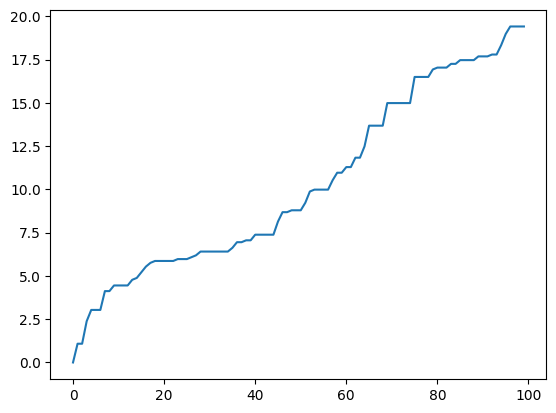

In [162]:
avg_return = compute_avg_return_print(evaluation_env, C51_agent.policy, 20)
print(avg_return)